In [2]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt
from moge.network.omics_distance import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import the TCGA cancer data

In [4]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'wb') as file:
#     luad_data = pickle.load(file)
    pickle.dump(luad_data, file)

In [3]:
folder_path = "/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/data/datasets/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Unmatched lncRNAs 12727
Unmatched lncRNAs after gencode: 1033
Unmatched lncRNAs after lncBase: 812
Unmatched lncRNAs after HGNC: 758
Unmatched lncRNAs after lncipedia: 622
PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20157)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:994: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID", how="left")


Processed genes info for  MIR
Processed genes info for  LNC


In [5]:
LNC = luad_data.LNC.get_genes_info()
MIR = luad_data.MIR.get_genes_info()
GE = luad_data.GE.get_genes_info()
print(GE.columns)
print(MIR.columns)
print(LNC.columns)

Index(['Transcript ID', 'Gene ID', 'Gene description', '3P-seq tags',
       'locus_type', 'location', 'gene_family', 'gene_family_id',
       'Transcript sequence', 'GO Terms', 'Disease association', 'Chromosome',
       'Chromosome arm', 'Chromosome region', 'Transcript length'],
      dtype='object')
Index(['miR family', 'Seed+m8', 'Mature sequence', 'Family Conservation?',
       'MiRBase Accession', 'MiRBase ID', 'location', 'ensembl_gene_id',
       'Disease association', 'locus_type', 'Transcript sequence',
       'Transcript length', 'GO Terms', 'Rfams'],
      dtype='object')
Index(['Gene ID', 'Gene Name', 'HGNC Gene Name', 'Transcript id',
       'Transcript name', 'Transcript type', 'tag', 'Chromosome', 'start',
       'end', 'Strand', 'locus_type', 'Transcript sequence',
       'Disease association', 'GO Terms', 'Rfams'],
      dtype='object')


In [8]:
LNC

,Gene ID,Gene Name,HGNC Gene Name,Transcript id,Transcript name,Transcript type,tag,Chromosome,start,end,Strand,locus_type,Transcript sequence,Disease association,GO Terms,Rfams
ENSG00000005206,ENSG00000005206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000031544,ENSG00000031544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC000061.1,ENSG00000083622,AC000061.1,NaN,ENST00000456270,AC000061.1-201,antisense,basic,chr7,117604791.0,117604989.0,-,antisense,TGAAAACTTCCTGAGGCCTCCTCAGAAGCAGATGCTGCTATGCTTC...,NaN,NaN,NaN
ENSG00000088970,ENSG00000088970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IGF2-AS,ENSG00000099869,IGF2-AS,IGF2-AS,ENST00000445504|ENST00000381361|ENST00000381363,IGF2-AS-203|IGF2-AS-201|IGF2-AS-202,antisense,basic,chr11,2146245.0,2147807.0,+,antisense,GGCCCGCGGGCTAGAGGCACTTTACCGCCCGGCGGGAGCGCCTCTC...,hepatocellular carcinoma|prostate cancer|type ...,NaN,NaN
TPTEP1,ENSG00000100181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000104691,ENSG00000104691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000110347,ENSG00000110347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC087235.1,ENSG00000115934,AC087235.1,NaN,ENST00000538297,AC087235.1-201,lincRNA,basic,chr12,23181334.0,23182623.0,-,lincRNA,CCCGCCATGATCGTGAGGCCTCCCCAGCGATGTGGAACTGCTGGAG...,NaN,NaN,NaN
PINK1-AS,ENSG00000117242,PINK1-AS,PINK1-AS,ENST00000451424,PINK1-AS-201,antisense,overlapping_locus|basic,chr1,20642657.0,20643118.0,-,antisense,ACTTTGAATTGCTAAAAGTGGCATTTTTCCTATGTGCAGTCACTCC...,diabetes mellitus|parkinson's disease,NaN,NaN


In [4]:
# node_list = GE[GE["gene_family"].notnull()].index[0:1000]
node_list = GE.index
# correlation_dist = compute_expression_correlation_dists(luad_data, modalities=["GE"],
#                                                         node_list=node_list, absolute_corr=True,
#                                                         squareform=False)
affinity = compute_annotation_affinities(GE, node_list=node_list,
                features=["locus_type", "gene_family_id", "location"], 
#                features=["Family", "tag", "Strand", "Chromosome"], 
#                                          correlation_dist=correlation_dist,
                                        nanmean=False, 
#                                          weights=[1, 1, 0.5, 0.5, 5],
                                        )


Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing location , dtype: object , shape: (20157,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:165: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:167: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:14: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(adj_list, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:15: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(adj_list, k_power)))


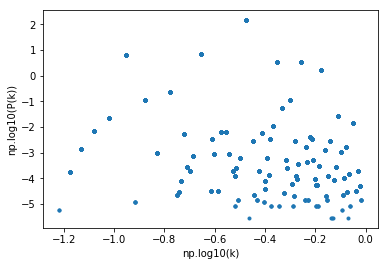

0.06380349819767342

In [5]:
from moge.evaluation.utils import get_scalefree_fit_score
from scipy.sparse import triu
from scipy.spatial.distance import squareform


affinities = squareform(affinity, checks=False)
adj_list = affinities[np.where(~np.isnan(affinities.data))].reshape((-1))

get_scalefree_fit_score(adj_list, plot=True)

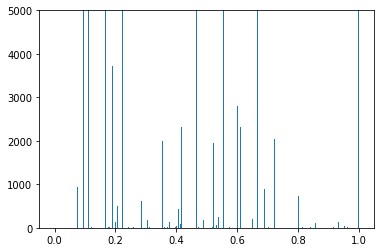

In [6]:
plt.hist(affinity[np.where(~np.isnan(affinity))].reshape((-1)), bins=500)
plt.ylim(top=5000)
plt.show()

In [7]:
threshold=0.70
print("threshold at", threshold,":",(affinity > threshold).sum())
# print("threshold at", threshold,":",(affinity < 0.01).sum())

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


threshold at 0.7 : 59560


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


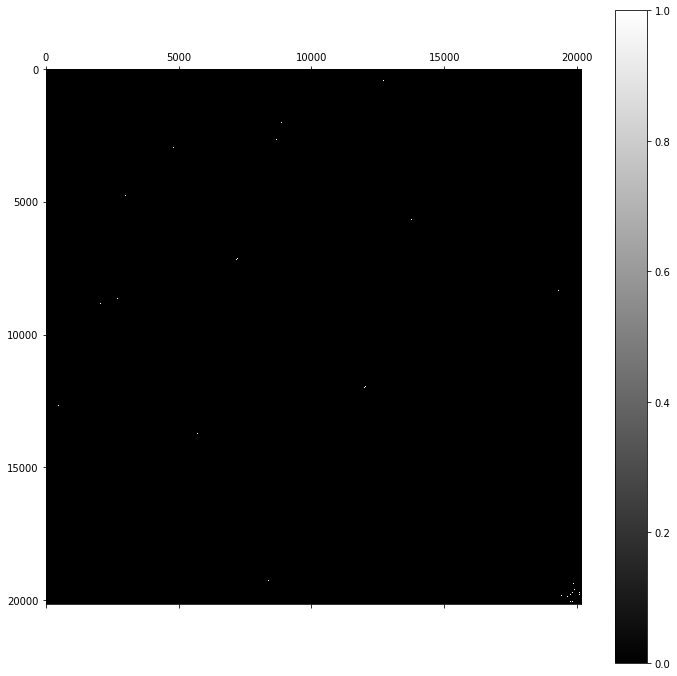

In [8]:
matrix_heatmap(np.array(affinity>threshold, dtype=float))

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


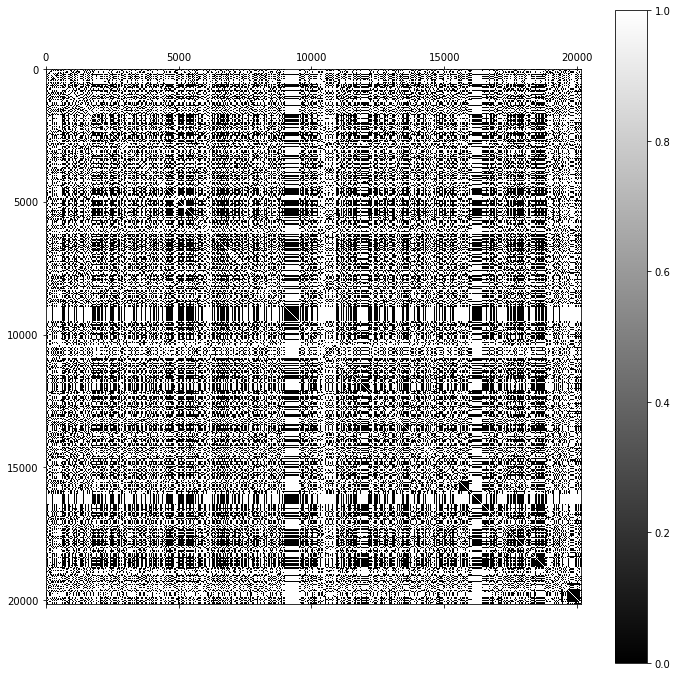

In [9]:
matrix_heatmap(np.array(affinity<0.01, dtype=float))

# Heterogeneous Network

In [13]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: 1992
Total nodes (filtered): 32742


## Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [110]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


59821 undirected positive edges (type='u') added.
299105 undirected negative edges (type='u_n') added.


In [111]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.85, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=False,
                                        features=["locus_type", "gene_family_id", "location"], 
                                        weights=[1, 3, 1],
                                        compute_correlation=False)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing location , dtype: object , shape: (20157,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:165: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:167: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)


23644 undirected positive edges (type='u') added.
118220 undirected negative edges (type='u_n') added.


In [112]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing Disease association , dtype: object , shape: (1870,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


701 undirected positive edges (type='u') added.
3505 undirected negative edges (type='u_n') added.


In [113]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["Family", "Rfams"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing Family , dtype: object , shape: (1870,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Rfams , dtype: object , shape: (1870,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


683 undirected positive edges (type='u') added.
3415 undirected negative edges (type='u_n') added.


In [114]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.3,
                                        negative_sampling_ratio=5.0, 
                                        nanmean=False,
                                        features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome"],
                                        weights=[1, 1, 1, 0.5, 0.5, 5],
                                        compute_correlation=True)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Transcript type , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing tag , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Strand , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Correlation distance (80714865,)
13759 undirected positive edges (type='u') added.
68795 undirected negative edges (type='u_n') added.


In [115]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Family", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Family , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


463 undirected positive edges (type='u') added.
2315 undirected negative edges (type='u_n') added.


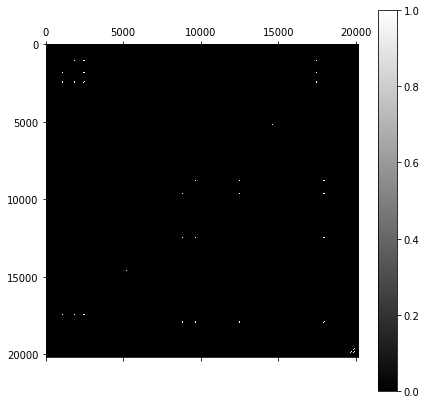

In [116]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

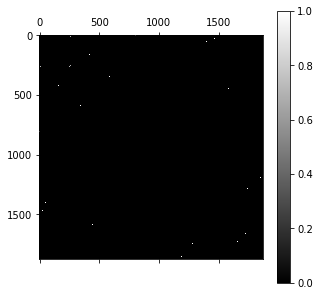

In [117]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

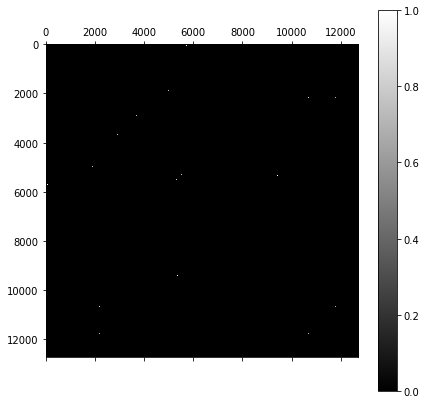

In [118]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [6]:
# IMPORT Affinity Edgelist
network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_NoExpression_affinity.edgelist", 
    file="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
    is_directed=False)

In [119]:
# WRITE Affinity Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"]), 
#                   "moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#                   data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


# Add Regulatory Interaction edges

In [4]:
mirtarbase_new = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True, data=False)
mirtarbase_old = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False, data=False)
mirtarbase_diff = list(set(mirtarbase_new) - set(mirtarbase_old))
len(mirtarbase_diff)

64749

In [14]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

Adding edgelist with 1759 total unique MIR genes (source), but only matching 1618 nodes
Adding edgelist with 15064 total unique GE genes (target), but only matching 14659 nodes
377318 edges added.


In [13]:
starbase_new = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=1, data=False)
starbase_old = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2, data=False)
starbase_diff = list(set(starbase_new) - set(starbase_old))
len(starbase_diff)

1516287

In [6]:
biogrid_new = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, 
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.5.169.tab2.txt')
biogrid_old = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, 
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt')
biogrid_diff = list(set(biogrid_new) - set(biogrid_old))
len(biogrid_diff)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


33522

In [8]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(),
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="BioGRID")

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Adding edgelist with 13318 total unique GE genes (source), but only matching 12768 nodes
Adding edgelist with 19429 total unique GE genes (target), but only matching 14972 nodes
313724 edges added.


In [24]:
pd.read_table(luad_data.LNC.starBase_miRNA_lncRNA_file_path)

,name,mirAccession,geneName,targetSites,bioComplex,clipReadNum,cancerNum
0,hsa-miR-200b-3p,MIMAT0000318,CTA-204B4.6,1,1,1,-1
1,hsa-miR-200b-3p,MIMAT0000318,CTD-2630F21.1,1,8,190,-1
2,hsa-miR-200b-3p,MIMAT0000318,CTB-92J24.2,1,1,8,-1
3,hsa-miR-200b-3p,MIMAT0000318,RP11-473I1.10,1,2,14,-1
4,hsa-miR-200b-3p,MIMAT0000318,AC005154.5,1,1,22,-1
5,hsa-miR-200b-3p,MIMAT0000318,RP13-507I23.1,1,2,0,-1
6,hsa-miR-200b-3p,MIMAT0000318,RP11-18F14.2,2,1,14,-1
7,hsa-miR-200b-3p,MIMAT0000318,RP11-214C8.5,1,1,18,-1
8,hsa-miR-200b-3p,MIMAT0000318,OIP5-AS1,1,3,57,-1
9,hsa-miR-200b-3p,MIMAT0000318,CTD-3099C6.9,1,1,23,-1


In [26]:
_24["geneName"].unique().shape

(1127,)

In [18]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_RNA_interactions(),
                                        modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.2,
                                        database="BioGRID")

KeyError: 'pairGeneType'

In [11]:
npinter_new = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, data=False)
npinter_old = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False, data=False)
npinter_diff = list(set(npinter_new) - set(npinter_old))
len(npinter_diff)

123486

In [14]:
from moge.network.heterogeneous_network import get_rename_dict
lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")

In [15]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
#                                         database="lncRNome")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="lncBase")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="NPInter")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="LncReg")

Adding edgelist with 702 total unique MIR genes (source), but only matching 631 nodes
Adding edgelist with 7235 total unique LNC genes (target), but only matching 2535 nodes
60186 edges added.


In [8]:
lnc2tar_low = luad_data.LNC.get_lncrna2target_low_throughput_interactions(data=False)
lnc2tar_high = luad_data.LNC.get_lncrna2target_high_throughput_interactions(data=False)
lnc2tar_diff = list(set(lnc2tar_low) - set(lnc2tar_high))
len(lnc2tar_diff)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


1277

In [16]:
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_high_throughput_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_low_throughput_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncrna2target_low")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRInter_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncRInter")

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Adding edgelist with 61 total unique LNC genes (source), but only matching 17 nodes
Adding edgelist with 28866 total unique GE genes (target), but only matching 16337 nodes
65655 edges added.
Adding edgelist with 170 total unique LNC genes (source), but only matching 83 nodes
Adding edgelist with 315 total unique GE genes (target), but only matching 252 nodes
522 edges added.


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: x[:-1] + "-" + x[-1])


# Filter the node_list

In [17]:
isolates = list(nx.isolates(network.G))
len(isolates)

2585

In [18]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates]
network.node_list = [node for node in network.node_list if node not in isolates]

In [13]:
# network.remove_extra_nodes() # Also makes network unmutable

In [19]:
network.G.number_of_nodes()

57133

In [20]:
len(network.node_list)

32697

In [1]:
# WRITE/READ FULL network
import pickle
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_lncrna2target_lncrinter.train.pickle', 
          'rb') as file:
    # pickle.dump(network, file)
    network = pickle.load(file)

In [2]:
len(network.get_edgelist(edge_types="u", node_list=network.node_list))

95126

# Split train-test by edges

In [45]:
import pickle
# WRITE READ network
with open('moge/data/LMN_future_recall/Predict/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network = pickle.load(file)

In [27]:
from moge.evaluation.utils import split_train_test_edges

network_train, test_edges, val_edges = split_train_test_edges(network, network.node_list, 
#                                                                            databases=,
                                                          test_frac=.00, val_frac=.20, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
edges_to_remove 345875
edges_to_remove (after MST) 345875
test_edges_size 0
val_edges_size 69175
Removed 0 test, and 69175 val, type ['d'] edges


In [28]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581
MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


# Split train-test by nodes

In [ ]:
from moge.evaluation.utils import split_train_test_nodes

network_train, test_edges, val_edges, test_nodes, val_nodes = split_train_test_nodes(network, network.nodes["LNC"],
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=True)

In [ ]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.val_node_list = test_nodes
network_val.val_node_list = val_nodes
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)
len(network_test.node_list), len(network_val.node_list)

In [ ]:
network_train.G.number_of_edges()

# Write train-test-val split as separate networks

In [29]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

In [30]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.full.edgelist", 
                  data=False)

In [6]:
# Write edgelist interactions only
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.interactions.edgelist",
                  data=False)

In [ ]:
# Write edgelist interactions only, database specific
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], databases=["miRTarBase"], node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/MIR/lmn_train.miRTarBase.interactions.edgelist",
                  data=False)

[autoreload of IPython.core.ultratb failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
  File "/opt/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/ultratb.py", line 128, in <module>
    import IPython.utils.colorable as colorable
AttributeError: module 'IPython' has no attribute 'utils'
]
[autoreload of prompt_t

[autoreload of _pytest.outcomes failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    if old_obj is None: continue
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    for type_check, update in UPDATE_RULES:
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    continue
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    for type_check, update in UPDATE_RULES:
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 265, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires 

## Network Info & Visualizations

In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

In [ ]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

In [ ]:
matrix_heatmap(csr_un.toarray())

In [ ]:
matrix_heatmap(csr_u.toarray())

In [ ]:
matrix_heatmap(csr_d.toarray())